In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import sys


In [4]:
import glob 
import os
import re
import pandas as pd

In [37]:
def to_scientific(value):
    return float(f"{value:.2e}")

In [5]:
folder = "../Results_Metropolis"
all_files = glob.glob(os.path.join(folder,"*.txt"))

pd.options.display.float_format = "{:.2e}".format
t_eq = 3000
pattern = fr"err_sampleN20_j_min_([+-]?\d+\.?\d*[eE][+-]?\d+|[+-]?\d+\.?\d*)_h_min_([+-]?\d+\.?\d*[eE][+-]?\d+|[+-]?\d+\.?\d*)_t_eq_{t_eq}_metropolis\.txt"

j_data = []
h_data = []
j_set = []
h_set = []
t_eq_set = []

for file in all_files:
    filename = os.path.basename(file)
    match = re.match(pattern, filename)
    if match:
        # Extract values as strings
        j_min_match, h_min_match = match.groups()[0:3]
        
        # Convert to float and format in scientific notation
        j_min_sci = float(format(float(j_min_match), ".2e"))
        h_min_sci = float(format(float(h_min_match), ".2e"))
        t_eq = int(t_eq)

        j_set.append(j_min_sci)
        h_set.append(h_min_sci)
        t_eq_set.append(t_eq)
    
    df = pd.read_csv(file, delimiter=' ', header=None)
    df.columns = ["MCS", "Err_j", "Err_h"]
    j_min_data = df["Err_j"].min()
    h_min_data = df["Err_h"].min()
    j_data.append(j_min_data)
    h_data.append(h_min_data)
df_my = pd.DataFrame(data = {"j_data":j_data, "j_set":j_set, "h_data":h_data,"h_set":h_set,"t_eq_set":t_eq_set})
df_my = df_my.sort_values(by=["h_set", "j_set"], ascending=[False, False])

In [6]:
f"{df_my['j_data'].min():.2e}"

'8.43e-04'

In [13]:
j_set_unique = df_my['j_set'].unique()
for i in j_set_unique:
    print(df_my[df_my['j_set']==i])

    j_data    j_set   h_data    h_set  t_eq_set
2 9.11e-04 9.10e-05 6.11e-04 4.20e-05      3000
7 9.13e-04 9.10e-05 5.33e-04 4.00e-05      3000
6 8.71e-04 9.10e-05 5.32e-04 3.80e-05      3000
    j_data    j_set   h_data    h_set  t_eq_set
1 8.43e-04 8.90e-05 5.72e-04 4.20e-05      3000
3 9.42e-04 8.90e-05 6.10e-04 4.00e-05      3000
4 9.31e-04 8.90e-05 5.60e-04 3.80e-05      3000
    j_data    j_set   h_data    h_set  t_eq_set
0 8.87e-04 8.70e-05 5.69e-04 4.20e-05      3000
8 9.04e-04 8.70e-05 6.13e-04 4.00e-05      3000
5 9.39e-04 8.70e-05 5.27e-04 3.80e-05      3000


In [6]:
import os

def sn(number):
    return f"{number:.2e}"


multiply_teq = 150
sample_data = "sampleN20"
input_data = "../Data/TidyData/" + sample_data + ".dat"

with open(input_data, 'r') as file:
    # Read the first line
    first_line = file.readline().strip()

    # Split the line into columns based on whitespace
    columns = first_line.split(',')

    # Count the number of columns
    nspins = len(columns)

t_eq = multiply_teq * nspins
use_exact = 'true'

j_min_set = [sn(9.17e-04), sn(9.17e-04), sn(9.17e-04)]
h_min_set = [sn(5.76e-04), sn(5.76e-04), sn(5.76e-04)]
#t_eq_set = [t_eq for i in range(len(j_min_set))]
method_set = [use_exact for i in range(len(j_min_set))]
filename_set = ["sampleN20" for i in range(len(j_min_set))]

filename = f"multithread_local.sh"

a = "#!/bin/bash\n\n"

b = "\t# Define uma função que contêm o código para rodar em paralelo\n"
c = "\trun_code() {\n"
c1 = """\t\tlocal \t filename="$1" \n"""
c2 = """\t\tlocal \t err_min_j="$2" \n"""
c3 = """\t\tlocal \t err_min_h="$3" \n"""
c4 = """\t\tlocal \t exact_solution="$4" \n"""
d = f"\t\ttime ./main_single.sh $filename $err_min_j $err_min_h $exact_solution\n"
d1 = """\t\techo "running: $filename $err_min_j $err_min_h $exact_solutions"\n """
d2 = "\t\tsleep 2\n"
e = "\t\t}\n"
f = "# Exportar a função usando o módulo Parallel\n"
g = "export -f run_code\n\n"

parameters = [str((i,j,k,l)) for i,j,k,l in zip(filename_set, j_min_set, h_min_set, method_set)]
aux_lst = [parameters[i].replace(',','') for i in range(len(parameters))]
my_parameters = ' '.join(aux_lst)

h = f"args=({my_parameters})\n\n"
i = "# Executa os comandos em paralelo\n"
j = """for group in "${args[@]}"; do\n"""
k = """\tclean_group=$(echo "$group" | tr -d '()' | tr -d "'" | xargs)\n"""
l = """\techo "$clean_group"\n"""
m = "done | parallel -j $(nproc) --colsep ' ' run_code {1} {2} {3} {4} "
lst_loop = [a+b+c+c1+c2+c3+c4+d+d1+d2+e+f+g+h+i+j+k+l+m]
# j = """for arg_set in "${args[@]}"; do\n"""
# k = "\t(\n"
# l = "\t\t# Passa os argumentos individuais para a função\n"
# m ="""\t\trun_code "${arg_set[@]}" \n"""
# n = "\t) &\n"
# o = "done\n\n"
# o1 ="# Wait for all background processes to finish\n"
# p = "wait"
#lst_loop = [a+b+c+c1+c2+c3+c4+d+d1+d2+e+f+g+h+i+j+k+l+m+n+o+o1+p]
x = open("../Scripts/" +filename, "w") # argument w: write if don't exist file

for k in lst_loop:
    x.write(k)
x.close()

def permission_run():
    os.system("chmod +x ../Scripts/multithread_local.sh")
permission_run()

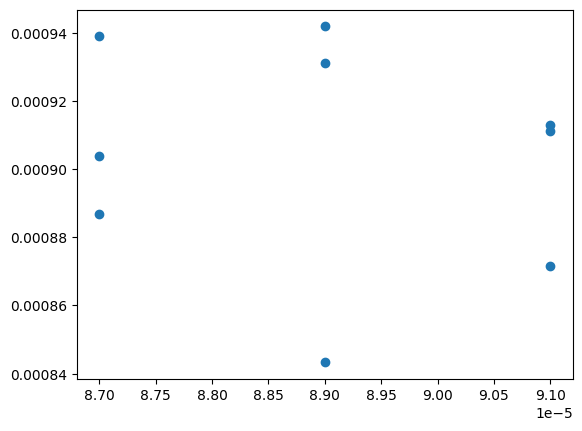

In [11]:
plt.plot(df_my['j_set'],df_my['j_data'],'o')
plt.show()

In [51]:
mean_j_data = f"{df_my["j_data"].mean():.2e}"
mean_j_data


'9.05e-04'

In [ ]:
import json

In [ ]:
f = open('../Results/sampleN20.json')

# returns JSON object as 
# a dictionary
data = json.load(f)
# Print all keys in the JSON dictionary
for key in data.keys():
    print(key)

In [ ]:
S_ising = data['S']
S_exp = data['S_obs']

In [ ]:
plt.plot(S_exp,S_ising,'o')
plt.show()

In [36]:
import re

# Updated pattern to match scientific notation values and ensure proper capture
pattern = r"err_sampleN20_j_min_([+-]?\d+\.?\d*[eE][+-]?\d+|[+-]?\d+\.?\d*)_h_min_([+-]?\d+\.?\d*[eE][+-]?\d+|[+-]?\d+\.?\d*)_t_eq_(\d+)_metropolis\.txt"

# Sample filename
filename = "err_sampleN20_j_min_1.23e-10_h_min_4.56e+20_t_eq_30_metropolis.txt"

# Match the pattern
match = re.match(pattern, filename)

if match:
    # Extract values as strings
    value1, value2, value3 = match.groups()
    
    # Print extracted values for debugging
    print(f"Extracted values: value1={value1}, value2={value2}, value3={value3}")
    
    try:
        # Convert to float and format in scientific notation
        value1_sci = format(float(value1), ".2e")
        value2_sci = format(float(value2), ".2e")
        value3_sci = format(float(value3), ".2e")  # Assuming value3 is an integer
        
        print(f"value1: {value1_sci}, value2: {value2_sci}, value3: {value3_sci}")
    except ValueError as e:
        print(f"Error converting value: {e}")
else:
    print("No match found")


Extracted values: value1=1.23e-10, value2=4.56e+20, value3=30
value1: 1.23e-10, value2: 4.56e+20, value3: 3.00e+01
